## Homework 4

The Abalone data set from UCI Machine learning repository is used. Given eight attributes, the task is to predict the number of rings. Seven of the attributes are continuous, and one is nominal (sex - male,female,infant). The nominal attribute was replaced with numbers 0, 1 and 2. It was treated as a 3-class classification problem by grouping classes 1-8, 9 and 10, and 11 onwards.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

lines = [line.rstrip('\n').split(',') for line in open('abalone.data.txt')]
dic = {'M':1, 'F':2, 'I':3} # Replacing first attribute with numbers
for ind, item in enumerate(lines):
    item[0]=dic.get(item[0],item[0])
lines=np.asarray(lines,dtype=float)

X=lines[:,0:-2]
Y=lines[:,-1]
Y[Y < 9] = 0  # splitting data into 3 classes
Y[Y == 9] = 1
Y[Y == 10] = 1
Y[Y > 10] = 2


## PCA on the dataset

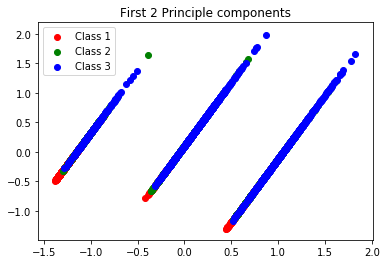

In [31]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 3)
X_reduced_pca = pca.fit(X).transform(X)

target_names=['Class 1','Class 2','Class 3']

plt.title('First 2 Principle components');
for c, i, target_name in zip("rgb", [0, 1, 2], target_names):
    plt.scatter(X_reduced_pca[Y == i, 0], X_reduced_pca[Y == i, 1], c=c, label=target_name)

plt.legend();
plt.show()

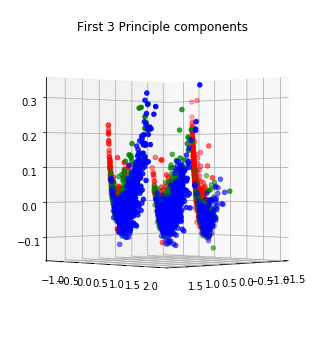

In [41]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1,2,1, projection='3d', elev=0, azim=45)
ax1.set_title('First 3 Principle components')

for c, i, target_name in zip("rgb", [0, 1, 2], target_names):
    ax1.scatter(X_reduced_pca[Y == i, 0], X_reduced_pca[Y == i, 1],X_reduced_pca[Y == i, 2], c=c, label=target_name)



2D or 3D PCA doesn't seem to result in any clear separable boundaries between the classes. I tried applying LDA, just to see if there was any better separation. It is a slightly better representation interms of classification, but still has considerable overlap for this data.

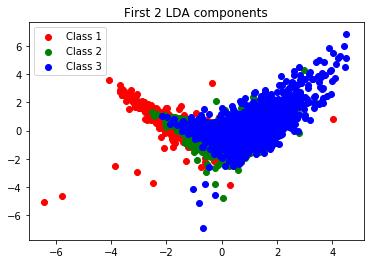

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_lda = lda.fit(X, Y).transform(X)

plt.title('First 2 LDA components');
for c, i, target_name in zip("rgb", [0, 1, 2], target_names):
    plt.scatter(X_lda[Y == i, 0], X_lda[Y == i, 1], c=c, label=target_name)

plt.legend();
plt.show()



## Clustering using GMM

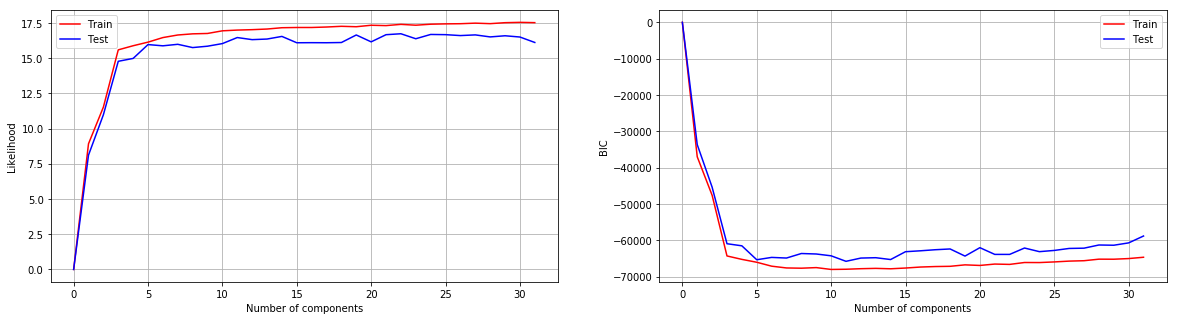

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture

X_train, X_test, y_train, y_test = \
train_test_split(X, Y, test_size=0.5,random_state=10,
                   shuffle=True,stratify=Y)

train_score=np.zeros((1,32))
test_score=np.zeros((1,32))
train_bic=np.zeros((1,32))
test_bic=np.zeros((1,32))

for K in range(1,32):  
    gmm = GaussianMixture(n_components=K,covariance_type='full') 
    gmm.fit(X_train)
    train_score[:,K]=gmm.score(X_train)
    test_score[:,K]=gmm.score(X_test)
    
    train_bic[:,K]=gmm.bic(X_train)
    test_bic[:,K]=gmm.bic(X_test)
    
fig, axes = plt.subplots(ncols=2, figsize=(20,5))

axes[0].plot(range(32),train_score.T,'r',label='Train')
axes[0].plot(range(32),test_score.T,'b',label='Test')
axes[0].set_xlabel('Number of components')
axes[0].set_ylabel('Likelihood')
axes[0].grid()
axes[0].legend(loc='best');

axes[1].plot(range(32),train_bic.T,'r',label='Train')
axes[1].plot(range(32),test_bic.T,'b',label='Test')
axes[1].set_xlabel('Number of components')
axes[1].set_ylabel('BIC')
axes[1].grid()
axes[1].legend(loc='best');

From the first graph which shows the variation of the likelihood for different number of components in the model, it can be seen that five gaussians are able to model the data. Increasing the number of components further seems to overfit on the given data. This can be seen from the Bayesian information criterion (BIC) plot aswell. A model with low BIC is preferred amoung multiple ones. 

## Supervised classification with 3 components

In [49]:
from sklearn.metrics import accuracy_score
gmm = GaussianMixture(n_components=3,covariance_type='full') 
gmm.fit(X_train)

train_score=gmm.score(X_train)
test_score=gmm.score(X_test)
train_bic=gmm.bic(X_train)
test_bic=gmm.bic(X_test)

print('Without mean and covariance from data (unsupervised)')
print('Scores: ', train_score,test_score)
print('BIC: ', train_bic,test_bic)
print('Priors: ', gmm.weights_)


y_test_hat = gmm.predict(X_test)
print('classification accuracy: ',accuracy_score(y_test_hat, y_test))


gmm = GaussianMixture(n_components=3,covariance_type='full') 
gmm.fit(X_train)
gmm.weights = np.array([.66, .66, .66])
for k in range(3):
    data = X_train[y_train == k]  # data per component
    gmm.means_[k]       = np.mean(data, axis=0)
    gmm.covariances_[k] = np.cov(data, rowvar=0)

train_score=gmm.score(X_train)
test_score=gmm.score(X_test)
train_bic=gmm.bic(X_train)
test_bic=gmm.bic(X_test)

print('-'*70)
print('With mean and covariance from data (supervised)')
print('Scores: ',train_score,test_score)
print('BIC: ',train_bic,test_bic)

y_test_hat = gmm.predict(X_test)
print('Priors: ', gmm.weights_)
print('classification accuracy: ',accuracy_score(y_test_hat, y_test))



Without mean and covariance from data (unsupervised)
Scores:  15.58652533697929 14.773660425571697
BIC:  -64271.42587868225 -60906.398096551995
Priors:  [0.31034483 0.37691571 0.31273946]
classification accuracy:  0.5102920057443753
----------------------------------------------------------------------
With mean and covariance from data (supervised)
Scores:  -131386.20020916697 -130678.33868569332
BIC:  548669589.9774098 545974916.9839882
Priors:  [0.31034483 0.37691571 0.31273946]
classification accuracy:  0.48539971278123506


## Classificaion using SVM


In [10]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV,StratifiedKFold,cross_val_score

param_grid = [{'kernel': ['rbf'],   
               'C': [1, 10, 100], 
               'gamma': [1e-3, 1e-4, 'auto']},
              {'kernel': ['linear'], 
               'C': [1, 10, 100]},
              {'kernel': ['poly'], 
               'C': [1, 10, 100],
               'degree': [3, 4],
               'probability':[1]}]

inner_cv = StratifiedKFold(n_splits=3, shuffle=True)
outer_cv = StratifiedKFold(n_splits=3, shuffle=True)

hyp = GridSearchCV(svm.SVC(), param_grid, cv=inner_cv, 
                   n_jobs=-1,scoring='accuracy')
scores = cross_val_score(hyp, X, Y, cv=outer_cv, n_jobs=1) 

print(scores)
print('Mean classification accuracy: ',scores.mean())

[0.65326633 0.65948276 0.66594828]
Mean classification accuracy:  0.6595657887136833


In [11]:
hyp.fit(X_train, y_train)

print('Best score :',hyp.best_score_)
print('Best estimator: ' , hyp.best_estimator_)
print('Score used: ', hyp.scorer_)
print('Best parameters: ', hyp.best_params_)
print('No. of splits: ', hyp.n_splits_)


Best score : 0.6489463601532567
Best estimator:  SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Score used:  make_scorer(accuracy_score)
Best parameters:  {'gamma': 'auto', 'C': 100, 'kernel': 'rbf'}
No. of splits:  3


## Integrating standard scaler

In [15]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipe = make_pipeline(StandardScaler(), svm.SVC())
param_grid = [{'standardscaler__with_mean' : ['True'],
               'standardscaler__with_std' : ['True']},
              {'svc__kernel': ['rbf'],
               'svc__C': [0.01, 0.1, 1, 10],
               'svc__gamma': [1e-3, 1e-4, 'auto']},
              {'svc__kernel': ['linear'],
               'svc__C': [0.01, 0.1, 1, 10]}]

hyp = GridSearchCV(pipe, param_grid, cv=inner_cv, n_jobs=-1)
scores = cross_val_score(hyp, X, Y, cv=outer_cv, 
                         scoring='accuracy', n_jobs=1)

print('Mean classification accuracy: ',scores.mean())

Mean classification accuracy:  0.6674661966097593


Best classification accuracy was obtained by performing SVM on standardized inputs.